In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
from sklearn import preprocessing
import time
import seaborn as sns
import re
from gensim.models import word2vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import os
from keras.models import Sequential

from keras.layers import Embedding

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols


# Install spreadsheets and import authentication module.



c:\Users\Test\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
triplets_file = 'train_triplets.txt'
unique_tracks = 'unique_tracks.txt'

song_df_1 = pd.read_table(triplets_file,header=None)
song_df_1.columns = ['user_id', 'song_id', 'listen_count']

#Read song  metadata
song_df_2 = pd.read_csv(unique_tracks, sep="<SEP>", names=['track_id', 'song_id', 'artist_name', 'title'])
song_df_2.drop(columns='track_id', inplace=True)

C:\Users\Test\AppData\Local\Temp\ipykernel_10232\3537166491.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  song_df_2 = pd.read_csv(unique_tracks, sep="<SEP>", names=['track_id', 'song_id', 'artist_name', 'title'])


In [3]:
ebd = {}

In [4]:
index = len(song_df_1)//20
song_df_1 = song_df_1.iloc[:index]

In [5]:
le_song_id = preprocessing.LabelEncoder()
le_song_id.fit(song_df_2.song_id)
song_df_2.song_id = le_song_id.transform(song_df_2.song_id)
song_df_1.song_id = le_song_id.transform(song_df_1.song_id)

In [6]:
le_user_id = preprocessing.LabelEncoder()
song_df_1.user_id = le_user_id.fit_transform(song_df_1.user_id)

In [7]:
song_df = pd.merge(song_df_1, \
                   song_df_2.drop_duplicates(['song_id']), \
                   on="song_id", how="left")

In [8]:
song_df = song_df.fillna(value=0)

In [9]:
def zscore(x):
    return (x - x.mean()) / x.std()

norm = song_df.groupby('user_id')['listen_count'].transform(zscore)
song_df['listen_count'] = norm

song_df.head()

,user_id,song_id,listen_count,artist_name,title
0,36252,17370,-0.299,Jack Johnson,The Cove
1,36252,25443,-0.299,Billy Preston,Nothing from Nothing
2,36252,45995,0.519,Paco De Lucia,Entre Dos Aguas
3,36252,52765,-0.299,Josh Rouse,Under Cold Blue Stars
4,36252,52840,-0.299,The Dead 60s,Riot Radio (Soundtrack Version)


In [10]:
def min_max(x):
    return (x-x.min()) / (x.max() - x.min())

norm = song_df.groupby('user_id')['listen_count'].transform(min_max)
song_df['listen_count'] = norm

song_df.head()

,user_id,song_id,listen_count,artist_name,title
0,36252,17370,0.000,Jack Johnson,The Cove
1,36252,25443,0.000,Billy Preston,Nothing from Nothing
2,36252,45995,0.143,Paco De Lucia,Entre Dos Aguas
3,36252,52765,0.000,Josh Rouse,Under Cold Blue Stars
4,36252,52840,0.000,The Dead 60s,Riot Radio (Soundtrack Version)


In [11]:
song_df = song_df.fillna(value=0)

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
def build_rating_sparse_tensor(song_df):
  indices = song_df[['user_id', 'song_id']].values
  values = song_df['listen_count'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[song_df_1.shape[0], song_df_2.shape[0]])

In [12]:
def split_dataframe(df, holdout_fraction=0.1):

  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

def build_rating_sparse_tensor(song_df):
  indices = song_df[['user_id', 'song_id']].values
  values = song_df['listen_count'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[song_df_1.shape[0], song_df_2.shape[0]])

def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss


In [13]:
train, test = split_dataframe(song_df, holdout_fraction=0.1)


In [14]:
train

(2176811, 5)

In [15]:
test.shape

(241868, 5)

In [14]:
import tensorflow as tf
import collections
import matplotlib.pyplot as plt

class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None
        self._saver = tf.compat.v1.train.Saver()

    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
              optimizer=tf.compat.v1.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
                tf.compat.v1.global_variables_initializer(),
                tf.compat.v1.local_variables_initializer())
            if self._session is None:
                self._session = tf.compat.v1.Session()
                with self._session.as_default():
                    self._session.run(tf.compat.v1.global_variables_initializer())
                    self._session.run(tf.compat.v1.tables_initializer())
                    tf.compat.v1.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(
                        ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                num_subplots = len(metrics) + 1
                fig = plt.figure()
                fig.set_size_inches(num_subplots * 10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i + 1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()

            return results


In [145]:
import pickle
class CFModel(object):
  def __init__(self, embedding_vars, loss, metrics=None):
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.compat.v1.train.GradientDescentOptimizer):
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.compat.v1.global_variables_initializer(),
          tf.compat.v1.local_variables_initializer())
      if self._session is None:
        self._session = tf.compat.v1.Session()
        with self._session.as_default():
          self._session.run(tf.compat.v1.global_variables_initializer())
          self._session.run(tf.compat.v1.tables_initializer())
          tf.compat.v1.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results
    

  def save_model(self, file_path):
    if self._session is None:
        raise ValueError("No session found. Train the model before saving.")

    model_data = {
        'embedding_vars': {k: self._session.run(v).tolist() for k, v in self._embedding_vars.items()},
        'loss': self._loss.eval(session=self._session).tolist(),
        'metrics': {k: {kk: self._session.run(vv).tolist() for kk, vv in v.items()} for k, v in self._metrics.items()}
    }

    with open(file_path, 'wb') as f:
        pickle.dump(model_data, f)

    print(f"Model saved to {file_path}")

  @staticmethod
  def load_model(file_path):
      with open(file_path, 'rb') as f:
          model_data = pickle.load(f)

      embedding_vars = {k: tf.Variable(v, name=k) for k, v in model_data['embedding_vars'].items()}
      loss = tf.constant(model_data['loss'], name='loss')
      metrics = {k: {kk: tf.constant(vv, name=kk) for kk, vv in v.items()} for k, v in model_data['metrics'].items()}

      return CFModel(embedding_vars, loss, metrics)

In [146]:
def gravity(U, V):
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):

  train_ratings, test_ratings = split_dataframe(ratings)

  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random.normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random.normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "song_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 1: train_error_observed=0.065493, test_error_observed=0.065806, observed_loss=0.065493, regularization_loss=0.017502, gravity_loss=0.000219

C:\Users\Test\AppData\Local\Temp\ipykernel_12840\355815710.py:59: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim([1, num_iterations])


[{'train_error_observed': 0.06549317, 'test_error_observed': 0.065806024},
 {'observed_loss': 0.06549317,
  'regularization_loss': 0.017501598,
  'gravity_loss': 0.00021878992}]

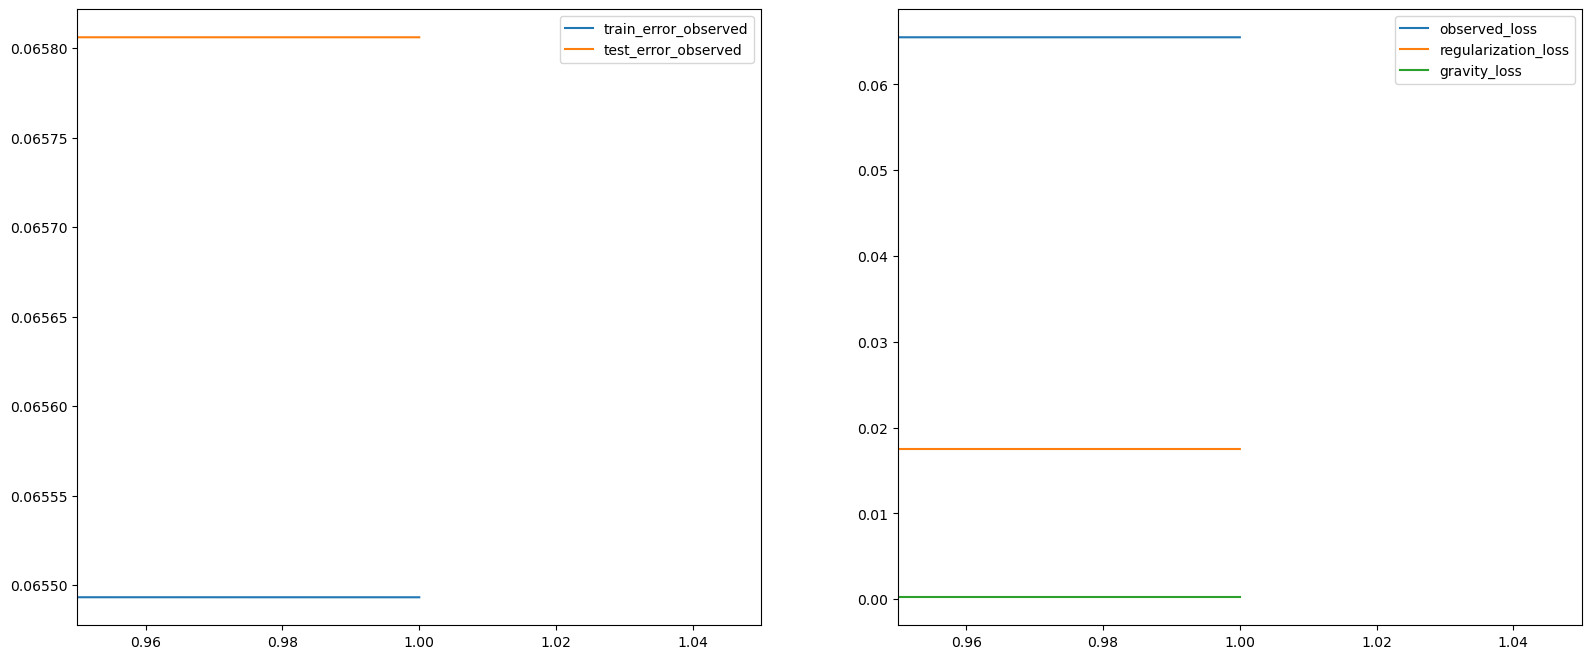

In [147]:
tf.compat.v1.disable_eager_execution()
reg_model = build_regularized_model(
    song_df, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=1, learning_rate=20.)

In [148]:
music = song_df_2

In [149]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [150]:
def user_recommendations(model, user=0, measure=DOT, exclude_rated=False, k=20):
  scores = compute_scores(
      model.embeddings["user_id"][user], model.embeddings["song_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'song_id': music['song_id'],
      'titles': music['title'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))  

In [151]:
user_id = 88
user_recommendations(reg_model, user_id, measure=DOT, k=20)

,dot score,song_id,titles
531478,0.088,155931,Love And Marriage Rap
886763,0.069,62583,Beaufort 9_ And Rising
233305,0.068,384418,Linnanmäki palaa
588992,0.067,497831,Any Minute Now / Thinking Back
785419,0.066,678096,Chasing Song
...,...,...,...
788736,0.063,358423,Giralda
541024,0.062,162760,If I Were A Carpenter
163283,0.062,935577,Circle Of Fire
968421,0.062,655393,One Of A Kind


In [161]:
user_id = 88
rmt(abc, user_id, measure=DOT, k=20)

,dot score,song_id,titles
531478,0.088,155931,Love And Marriage Rap
886763,0.069,62583,Beaufort 9_ And Rising
233305,0.068,384418,Linnanmäki palaa
588992,0.067,497831,Any Minute Now / Thinking Back
785419,0.066,678096,Chasing Song
...,...,...,...
788736,0.063,358423,Giralda
541024,0.062,162760,If I Were A Carpenter
163283,0.062,935577,Circle Of Fire
968421,0.062,655393,One Of A Kind


In [139]:
reg_model.embeddings

{'user_id': array([[-0.01327621,  0.01001761,  0.03462171, ..., -0.0105927 ,
         -0.05643967, -0.01671445],
        [ 0.06585854,  0.03284265,  0.03771687, ...,  0.07030863,
          0.03730576,  0.0892252 ],
        [ 0.08663431,  0.09086262, -0.01195675, ...,  0.0464686 ,
         -0.00907952,  0.0272523 ],
        ...,
        [-0.05994461, -0.08670287, -0.07524022, ...,  0.03090209,
         -0.01808574,  0.02306075],
        [ 0.0465363 ,  0.06207476,  0.06668616, ...,  0.03694432,
          0.02842454, -0.06398445],
        [-0.04122817, -0.01679331,  0.02976293, ...,  0.09664251,
         -0.00410302, -0.013474  ]], dtype=float32),
 'song_id': array([[ 0.08477838, -0.08578871,  0.03951568, ...,  0.04335651,
          0.00844142, -0.04375473],
        [ 0.03788013,  0.06950765, -0.07038698, ..., -0.05497054,
          0.03841389,  0.04885069],
        [-0.07500263, -0.0739952 , -0.01668321, ..., -0.036364  ,
          0.00912705, -0.08685721],
        ...,
        [-0.02977

In [132]:
test_model =CFModel(reg_model.embeddings, reg_model._loss, reg_model._metrics)

In [153]:
reg_model.embeddings

{'user_id': array([[ 0.0429863 ,  0.05646355, -0.04855637, ..., -0.06561154,
          0.01531799, -0.03318745],
        [ 0.00145509,  0.09292258,  0.0014811 , ..., -0.08263901,
         -0.098404  , -0.0308403 ],
        [ 0.0172552 , -0.00379046, -0.00239297, ...,  0.07155141,
          0.06058032, -0.00584985],
        ...,
        [-0.02027095, -0.00205568, -0.00183537, ...,  0.05071212,
         -0.024619  ,  0.06195365],
        [-0.06875946,  0.0246831 , -0.07118452, ..., -0.06999686,
          0.03809119, -0.02240947],
        [ 0.07216349,  0.02277264,  0.0650614 , ..., -0.01102552,
         -0.02642722,  0.00536145]], dtype=float32),
 'song_id': array([[-0.02943712, -0.06290226, -0.04808345, ..., -0.01934304,
         -0.05825716,  0.02845825],
        [ 0.00653018,  0.01271902, -0.02527401, ..., -0.11100861,
         -0.07069216, -0.00510634],
        [-0.0180533 , -0.03757919, -0.07843295, ...,  0.02818949,
         -0.01316896,  0.05546903],
        ...,
        [-0.02595

In [155]:
test_model._embedding_vars

{'user_id': array([[-0.01327621,  0.01001761,  0.03462171, ..., -0.0105927 ,
         -0.05643967, -0.01671445],
        [ 0.06585854,  0.03284265,  0.03771687, ...,  0.07030863,
          0.03730576,  0.0892252 ],
        [ 0.08663431,  0.09086262, -0.01195675, ...,  0.0464686 ,
         -0.00907952,  0.0272523 ],
        ...,
        [-0.05994461, -0.08670287, -0.07524022, ...,  0.03090209,
         -0.01808574,  0.02306075],
        [ 0.0465363 ,  0.06207476,  0.06668616, ...,  0.03694432,
          0.02842454, -0.06398445],
        [-0.04122817, -0.01679331,  0.02976293, ...,  0.09664251,
         -0.00410302, -0.013474  ]], dtype=float32),
 'song_id': array([[ 0.08477838, -0.08578871,  0.03951568, ...,  0.04335651,
          0.00844142, -0.04375473],
        [ 0.03788013,  0.06950765, -0.07038698, ..., -0.05497054,
          0.03841389,  0.04885069],
        [-0.07500263, -0.0739952 , -0.01668321, ..., -0.036364  ,
          0.00912705, -0.08685721],
        ...,
        [-0.02977

In [157]:
import json
import numpy as np

# Giả sử reg_model.embeddings là dictionary chứa các mảng NumPy
data_to_save = {}
for key, value in reg_model.embeddings.items():
    if isinstance(value, np.ndarray):
        data_to_save[key] = value.tolist()  # Chuyển đổi ndarray sang list
    else:
        data_to_save[key] = value  # Giữ nguyên nếu không phải ndarray

# Đường dẫn file để lưu
file_path = 'model_embeddings.json'

# Lưu dữ liệu xuống file JSON
with open(file_path, 'w') as f:
    json.dump(data_to_save, f)

print(f"Dữ liệu đã được lưu vào file {file_path}")


Dữ liệu đã được lưu vào file model_embeddings.json


In [126]:
test_model.embeddings

{'user_id': None, 'song_id': None}

In [127]:
def rmt(model, user=0, measure=DOT, exclude_rated=False, k=20):
  scores = compute_scores(
      model._embedding_vars["user_id"][user], model._embedding_vars["song_id"], measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'song_id': music['song_id'],
      'titles': music['title'],
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))  

In [135]:
user_id = 88
rmt(test_model, user_id, measure=DOT, k=20)

,dot score,song_id,titles
452096,0.083,975614,We Don't Play Guitars (Christian Vogel Remix)
707111,0.075,630,Gunfire
918041,0.075,676197,Transmission
169350,0.073,952187,She All That And More
482563,0.072,554238,2nd Skin (Geert Huinink's crushing remix)
...,...,...,...
308158,0.069,339782,Hallå i huvet
606644,0.069,36981,Butterfly (Album Version)
374328,0.068,400514,Radio Plays
367922,0.068,853654,Alguém Da Minha Família


In [158]:
import json
import numpy as np

def load_embeddings_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    ebd = {}
    for key, value in data.items():
        if isinstance(value, list):
            ebd[key] = np.array(value, dtype=np.float32)
        else:
            ebd[key] = value

    return ebd

# Đường dẫn file JSON chứa dữ liệu embeddings
file_path = 'model_embeddings.json'

# Đọc dữ liệu từ file JSON và chuyển đổi thành dict ebd với các mảng NumPy
ebd = load_embeddings_from_json(file_path)

In [159]:
abc = CFModel(ebd, None, None)

{'user_id': array([[ 0.0429863 ,  0.05646355, -0.04855637, ..., -0.06561154,
          0.01531799, -0.03318745],
        [ 0.00145509,  0.09292258,  0.0014811 , ..., -0.08263901,
         -0.098404  , -0.0308403 ],
        [ 0.0172552 , -0.00379046, -0.00239297, ...,  0.07155141,
          0.06058032, -0.00584985],
        ...,
        [-0.02027095, -0.00205568, -0.00183537, ...,  0.05071212,
         -0.024619  ,  0.06195365],
        [-0.06875946,  0.0246831 , -0.07118452, ..., -0.06999686,
          0.03809119, -0.02240947],
        [ 0.07216349,  0.02277264,  0.0650614 , ..., -0.01102552,
         -0.02642722,  0.00536145]], dtype=float32),
 'song_id': array([[-0.02943712, -0.06290226, -0.04808345, ..., -0.01934304,
         -0.05825716,  0.02845825],
        [ 0.00653018,  0.01271902, -0.02527401, ..., -0.11100861,
         -0.07069216, -0.00510634],
        [-0.0180533 , -0.03757919, -0.07843295, ...,  0.02818949,
         -0.01316896,  0.05546903],
        ...,
        [-0.02595